# Προσαρμοστική κατωφλίωση, επεκτείνοντας την βασική μέθοδο Otsu
## Παναγιώτης Τσιάβος Α.Μ. 2396

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from math import ceil, floor

Image Shape: (315, 200)


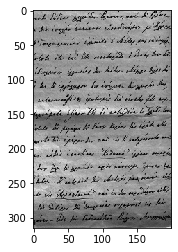

In [2]:
R = np.array(Image.open('trikoupi6_low.png'))
print("Image Shape:", R.shape)
plt.imshow(R, cmap="gray")

### Grayscale Conversion

O μέσος όρο των καναλιών Red, Green, Blue (δηλ. για καθε R,G,B γραμμή του πίνακα, έστω Χ) υπολογίζεται ως:
$$ X^{'} = \frac{R+G+B}{3}$$
 
Η numpy μας επιτρέπει την πράξη αυτήν με np.mean() όπου το όρισμα
axis=2 αντιστοιχεί στο να πάρει τις μέσες τιμές από τα τρία κανάλια χρώματος.

(axis = 0 θα ήταν κατά μέσο όρο σε γραμμές εικονοστοιχείων και axis = 1 θα ήταν κατά μέσο όρο σε στήλες)

In [3]:
def grayscaling(A):
    if(len(A.shape)==3):
        return np.mean(A, axis=2)
    return A

### Κατωφλίωση

Η παρακάτω συνάρτηση δέχεται ως είσοδο μια εικόνα (image) και έναν πινακα (ίδιου μεγέθους με εικόνα) απο κατώφλια (threshold_vals). Για κάθε εικονοστοιχείο (i,j) της εικόνας κατωφλιώνουμε με το αντιστοιχο κατωφλι (i,j) του πίνακα threshold_vals. 

In [4]:
def threshing(image, threshold_vals):
#     image_cp = R.copy()
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if R[row, col] <= threshold_vals[row, col]:
                image[row, col] = 0
            else:
                image[row, col] = 255
    return image

### Γειτονιά

Η παρακάτω συνάρτηση επιστρέφει μια γειτονιά ενός εικονοστοιχείου σε μια εικόνα, όπου:  
- <b>R:</b> Η εικόνα
- <b>i,j:</b> Η θέση του εικονοστοιχείου (i γραμμή, j στήλη)
- <b>d:</b> Το εύρος (width) γειτονιάς, το οποιό υπολογιζεται απο την συναρτήση otsu() με βάση το window_size)

In [5]:
def get_neighbors(R, i, j, d):
    return R[max(i-d,0): min(i+d+1, R.shape[0]), max(j-d,0):min(j+d+1, R.shape[1])].flatten()

### Υπολογισμός αντικειμενικής συνάρτησης για κατώφλι k

Η παρακάτω συνάρτηση υπολογίζει την αντικειμενική συνάρτηση μιάς γειτονίας για κατώφλι k.  
Αρχικά διατάσουμε τα εικόνοστοιχεία μια γειτονίας σε δύο κατηγορίες με βάση το κατώφλι.
Έπειτα υπολογίζουμε την μέση ένταση για κάθε κατηγορία καθως για όλη την γειτονιά και υπολόγιζουμε-επιστρέφουμε την διακύμανση.

In [6]:
def calc(W, k):
    pixels1 = W[W <= k]
    pixels2 = W[W > k]
    
    mu1 = np.mean(pixels1)
    mu2 = np.mean(pixels2)
    mu_all = np.mean(W)
    
    pi1 = len(pixels1) / (len(W))
    pi2 = len(pixels2) / (len(W))
    antikeimeniki_synartisi = pi1 * (mu1 - mu_all)**2 + pi2 * (mu2 - mu_all)**2
    return(antikeimeniki_synartisi)
    

### Κατωφλίωση Otsu

Η παρακάτω συνάρτηση υπολογίζει το καλύτερο κατώφλη για κάθε εικόνοστοιχείο μια εικόνας (image) με βάση την γειτονία (window_size).  
Για κάθε εικονοστοχείο της εικόνας υπολογίζουμε την αντικειμενική συνάρτηση με βάση την γειτονία για όλα τα κατώφλια [0,255], η επιλογή του καλύτερου k (κατώφλι) επιλέγεται ύστερα απο αυτή τη σειριακή αναζήτηση μεγιστοποιώντας την πόσοτητα της διακύμανσης.

$$k = \max_{0\leq k\leq255}(\sigma^{2}_{B}(k))$$

Τέλος επιστρέφουμε εναν πίνακα ίδιου μεγέθους οπου καθε θέση i,j αντιστοιχει στο καλύτερο κατώφλι για τις αντίστοιχες θέσης της αρχικής εικόνας.

In [7]:
def otsu(image, window_size):
    d = floor(window_size/2)     # width size for neighbors function.
    ret = np.zeros(image.shape)  # 2d array of (best) threshold values for every pixel in image
    row_size = image.shape[0]
    col_size = image.shape[1]
    
    for row in range(row_size):
        for col in range(col_size):
            k = 0
            best_s = 0
            neighbors = get_neighbors(image, row, col, d)  # Returns a flattened array of neighbor pixels

            for i in range(1, 256):
                obj_otsu = calc(neighbors, i)
            
                if (obj_otsu > best_s):
                    k = i
                    best_s = obj_otsu
                    
            ret[row, col] = k

    return ret
            

In [22]:
%%time
window_size = 5
threshold_vals = otsu(R, window_size)
threshold_image = threshing(R.copy(), threshold_vals)


Wall time: 13min 31s


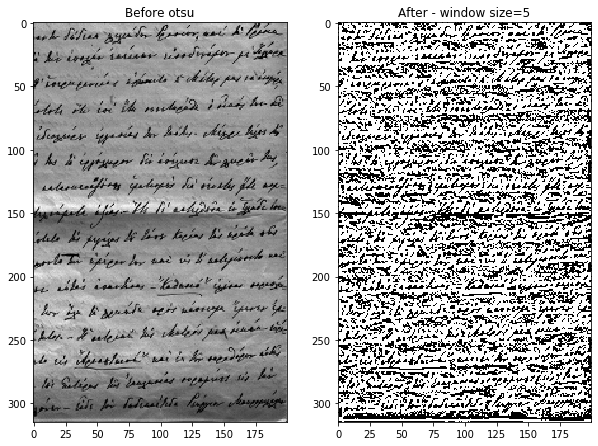

In [23]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.title("Before otsu")
plt.imshow(R, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("After - window size=5")
plt.imshow(threshold_image, cmap='gray')
plt.show()


In [24]:
%%time
window_size = 51
threshold_vals = otsu(R, window_size)
threshold_image = threshing(R.copy(), threshold_vals)

Wall time: 18min 49s


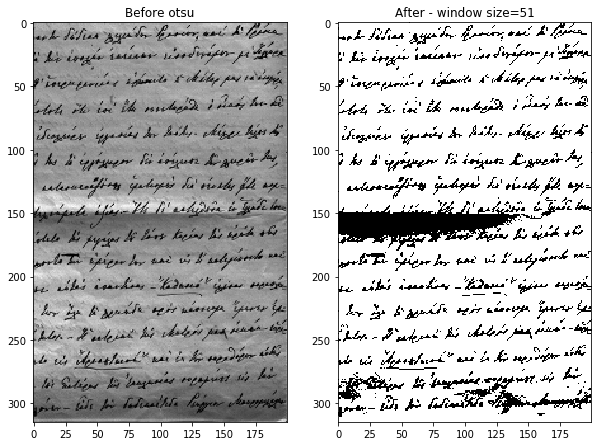

In [25]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.title("Before otsu")
plt.imshow(R, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("After - window size=51")
plt.imshow(threshold_image, cmap='gray')
plt.show()


In [26]:
%%time
window_size = 121
threshold_vals = otsu(R, window_size)
threshold_image = threshing(R.copy(), threshold_vals)

Wall time: 35min 45s


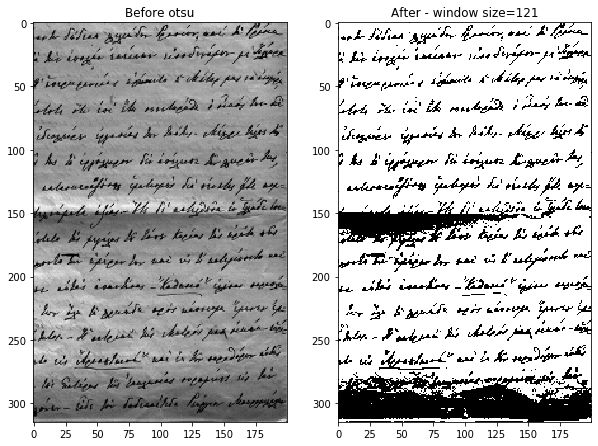

In [28]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.title("Before otsu")
plt.imshow(R, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("After - window size=121")
plt.imshow(threshold_image, cmap='gray')
plt.show()